In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

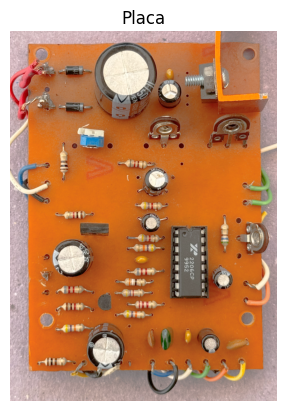

In [86]:
imagen = cv2.imread('placa.png')
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
plt.imshow(imagen_rgb)
plt.title('Placa') 
plt.axis('off') 
plt.show()

Escala de grises

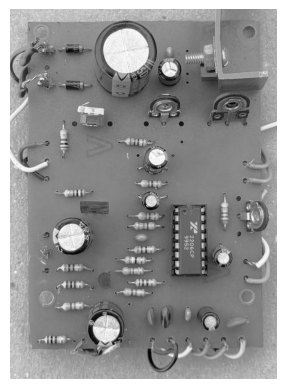

In [87]:
 # Convertir a escala de grises
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
plt.imshow(gris, cmap='gray')
plt.axis('off') 
plt.show()

Deteccion de bordes sin desenfoque 

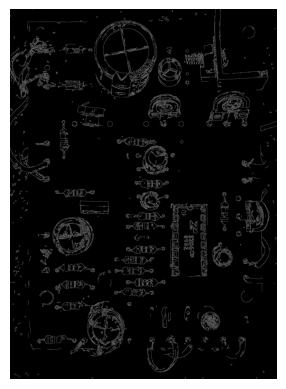

In [88]:
bordes = cv2.Canny(gris, 50, 150)
plt.imshow(bordes, cmap='gray')
plt.axis('off')
plt.show()


Desenfoque Gaussiano para reducir ruido

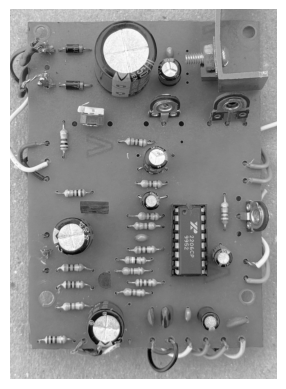

In [96]:
f_blur = cv2.GaussianBlur(gris,ksize=(3,3),sigmaX=2)
plt.imshow(f_blur, cmap='gray')
plt.axis('off')
plt.show()

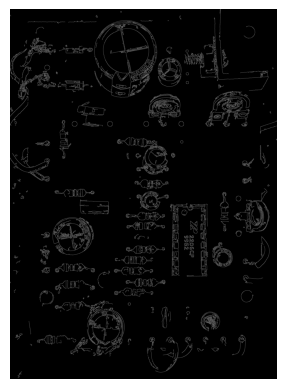

In [193]:
bordes_gauss = cv2.Canny(f_blur, 20, 150)
plt.imshow(bordes_gauss, cmap='gray')
plt.axis('off')
plt.show()

Cerramos contornos

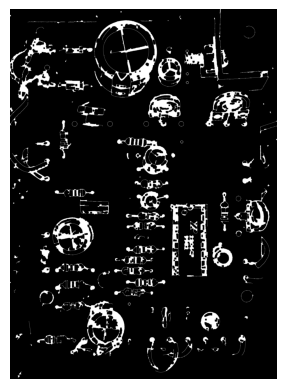

In [207]:

kernel = np.ones((3,3), np.uint8)
    
# Cerrar contornos
canny_cerrado = cv2.morphologyEx(bordes_gauss, cv2.MORPH_CLOSE, kernel, iterations=5)
plt.imshow(canny_cerrado, cmap='gray')
plt.axis('off')
plt.show()

Engrosamos los bordes

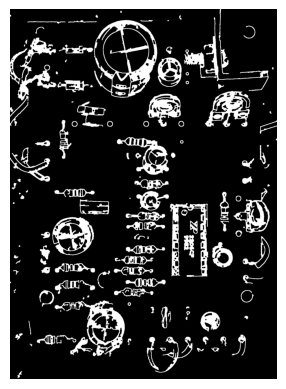

In [208]:
dilatado = cv2.dilate(canny_cerrado, kernel, iterations=2)
plt.imshow(dilatado, cmap='gray')
plt.axis('off')
plt.show()

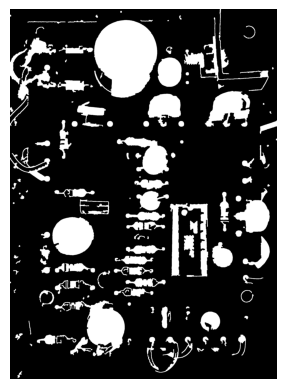

In [211]:
h, w = dilatado.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
im_floodfill = dilatado.copy()
cv2.floodFill(im_floodfill, mask, (0,0), 255)
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
imagen_binaria = dilatado | im_floodfill_inv
plt.imshow(imagen_binaria, cmap='gray')
plt.axis('off')
plt.show()

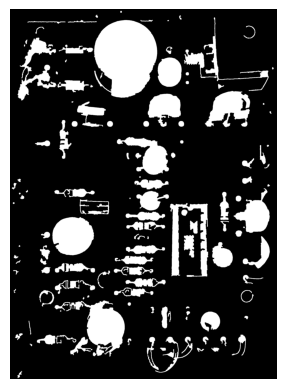

In [212]:
def imreconstruct(marker, mask, kernel=None):
    if kernel is None:
        kernel = np.ones((3, 3), np.uint8)
    while True:
        expanded = cv2.dilate(marker, kernel)
        expanded_intersection = cv2.bitwise_and(expanded, mask)
        if np.array_equal(marker, expanded_intersection):
            break
        marker = expanded_intersection
    return expanded_intersection

def imclearborder(img):
    marker = np.zeros_like(img)
    marker[0, :] = marker[-1, :] = 255
    marker[:, 0] = marker[:, -1] = 255
    border_elements = imreconstruct(marker, img)
    return cv2.subtract(img, border_elements)

img_cb = imclearborder(imagen_binaria)
plt.imshow(img_cb, cmap='gray')
plt.axis('off')
plt.show()

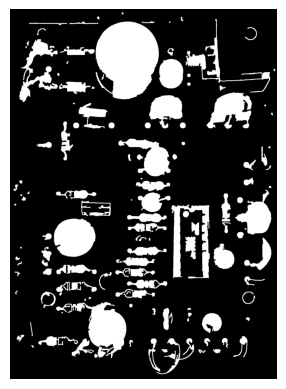

In [168]:
def imfillhole_v2(img):
    img_flood_fill = img.copy().astype("uint8")             # Genero la imagen de salida
    h, w = img.shape[:2]                                    # Genero una máscara necesaria para cv2.floodFill()
    mask = np.zeros((h+2, w+2), np.uint8)                   # https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#floodfill
    cv2.floodFill(img_flood_fill, mask, (0,0), 255)         # Relleno o inundo la imagen.
    img_flood_fill_inv = cv2.bitwise_not(img_flood_fill)    # Tomo el complemento de la imagen inundada --> Obtenog SOLO los huecos rellenos.
    img_fh = img | img_flood_fill_inv                       # La salida es un OR entre la imagen original y los huecos rellenos.
    return img_fh 
img_fh = imfillhole_v2(img_cb)

plt.imshow(img_fh, cmap='gray')
plt.axis('off')
plt.show()

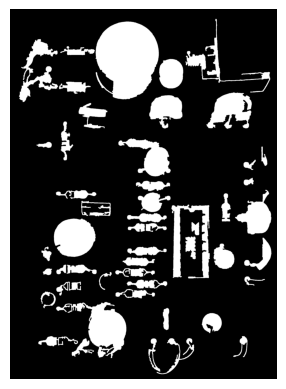

In [169]:
def remove_small_objects(img_bin, min_area=None):
    """
    Elimina objetos pequeños en una imagen binaria según un umbral de área.
    img_bin: imagen binaria con valores 0 y 255.
    min_area: área mínima para conservar un objeto.
    """
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(img_bin, connectivity=8)
    sizes = stats[1:, -1]  # El área de cada componente menos el fondo
    nb_components -= 1

    img_clean = np.zeros(img_bin.shape, dtype=np.uint8)

    for i in range(0, nb_components):
        if sizes[i] >= min_area:
            img_clean[output == i + 1] = 255

    return img_clean


img_sin_ruido = remove_small_objects(img_fh, min_area=2500)
plt.imshow(img_sin_ruido, cmap='gray')
plt.axis('off')
plt.show()


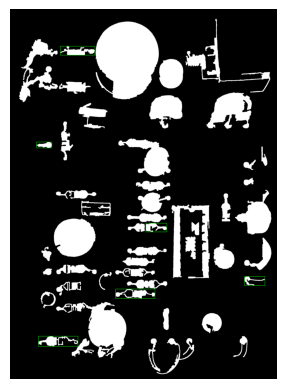

In [179]:
contours, _ = cv2.findContours(img_sin_ruido, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Copia en color para dibujar
output = cv2.cvtColor(img_sin_ruido, cv2.COLOR_GRAY2BGR)


# Detección de resistencias
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 500 or area > 10000:
        continue
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h != 0 else 0

    if aspect_ratio > 2:  # Ajustá este valor según tu imagen
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Rectángulo verde

# Mostrar resultado con los rectángulos dibujados
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


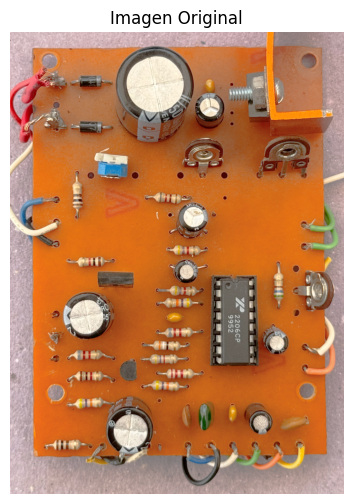

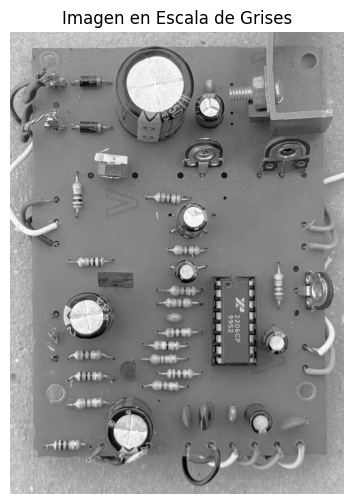

In [183]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar imagen
imagen = cv2.imread('placa.png')
imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

# Mostrar imagen original
plt.figure(figsize=(10, 6))
plt.imshow(imagen_rgb)
plt.title('Imagen Original')
plt.axis('off')
plt.show()

# Convertir a escala de grises
gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 6))
plt.imshow(gris, cmap='gray')
plt.title('Imagen en Escala de Grises')
plt.axis('off')
plt.show()

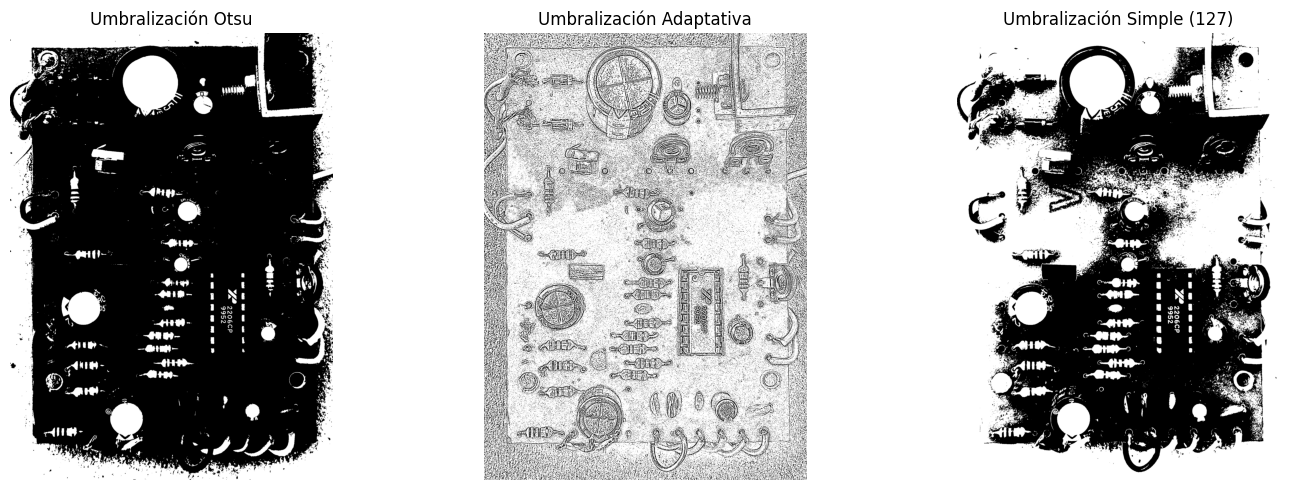

In [ ]:
# Umbralización automática (Otsu)
_, umbral_otsu = cv2.threshold(gris, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(umbral_otsu, cmap='gray')
plt.title('Umbralización Otsu')
plt.axis('off')

# Umbralización adaptativa
umbral_adaptativo = cv2.adaptiveThreshold(gris, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)

plt.subplot(1, 3, 2)
plt.imshow(umbral_adaptativo, cmap='gray')
plt.title('Umbralización Adaptativa')
plt.axis('off')

# Umbralización simple
_, umbral_simple = cv2.threshold(gris, 127, 255, cv2.THRESH_BINARY)

plt.subplot(1, 3, 3)
plt.imshow(umbral_simple, cmap='gray')
plt.title('Umbralización Simple (127)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Elegir la mejor umbralización para continuar
imagen_umbral = umbral_simple  # Cambiar si prefieres otra

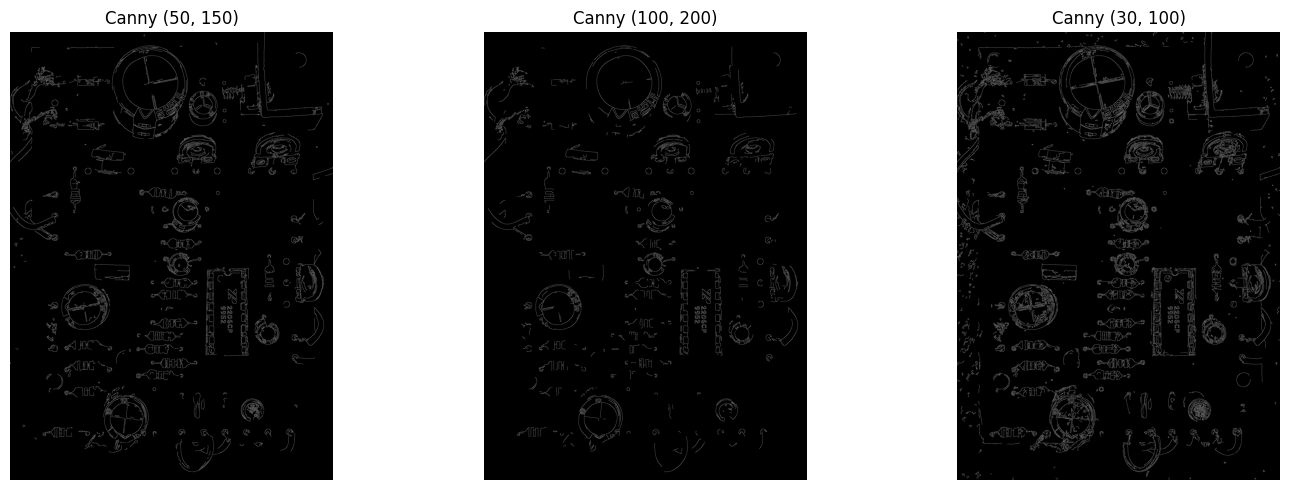

In [185]:
# Aplicar desenfoque gaussiano antes de Canny
blur = cv2.GaussianBlur(gris, (5, 5), 0)

# Detección de bordes Canny con diferentes parámetros
canny1 = cv2.Canny(blur, 50, 150)
canny2 = cv2.Canny(blur, 100, 200)
canny3 = cv2.Canny(blur, 30, 100)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(canny1, cmap='gray')
plt.title('Canny (50, 150)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(canny2, cmap='gray')
plt.title('Canny (100, 200)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(canny3, cmap='gray')
plt.title('Canny (30, 100)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Elegir los mejores parámetros
bordes_canny = canny1  # Cambiar si prefieres otros parámetros

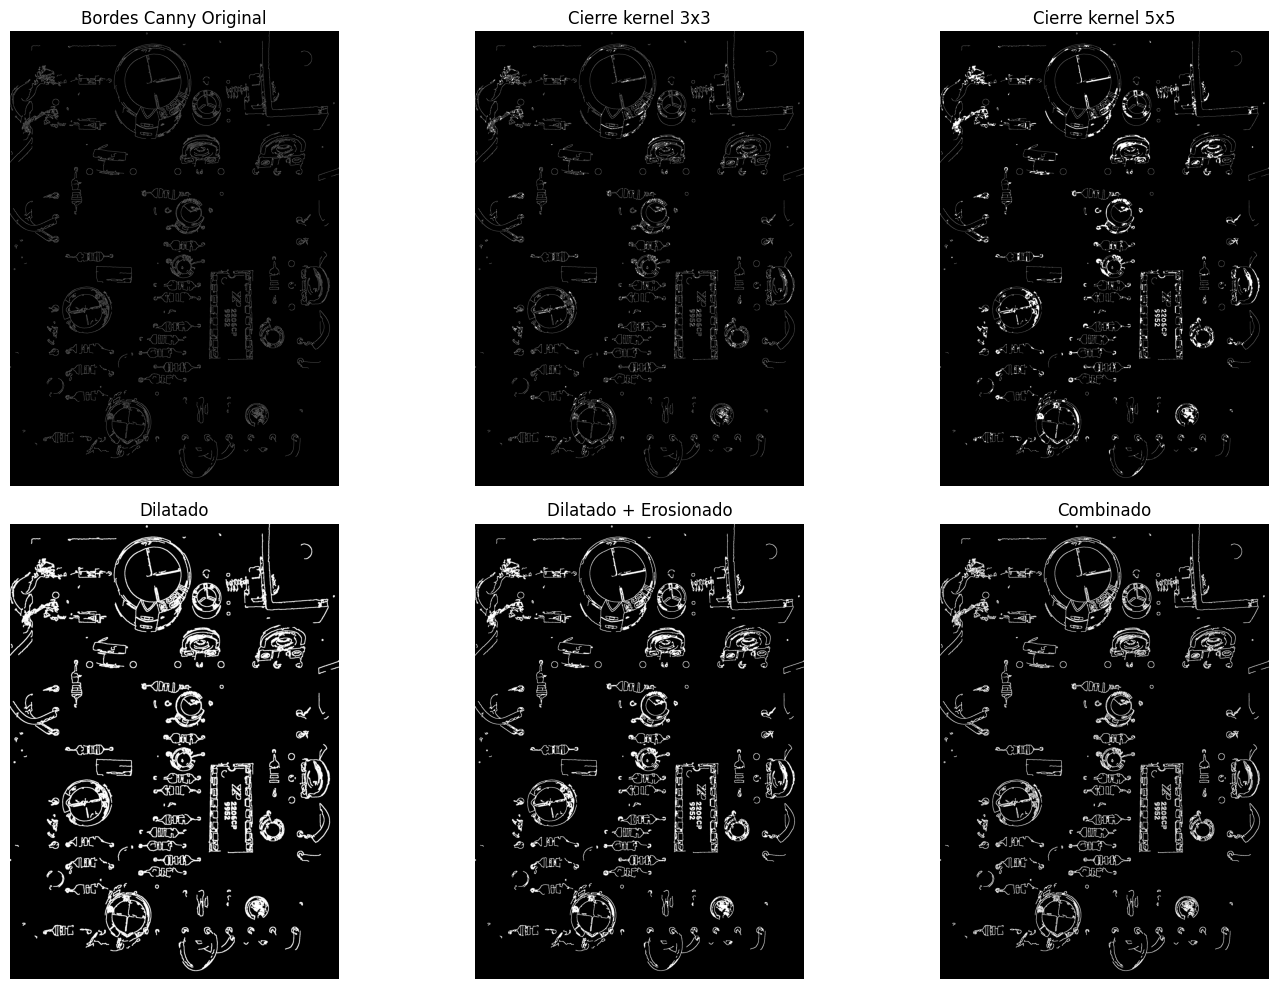

In [186]:
# Definir diferentes kernels
kernel_small = np.ones((3, 3), np.uint8)
kernel_medium = np.ones((5, 5), np.uint8)
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Operación de cierre (closing) para conectar bordes
cerrado1 = cv2.morphologyEx(bordes_canny, cv2.MORPH_CLOSE, kernel_small)
cerrado2 = cv2.morphologyEx(bordes_canny, cv2.MORPH_CLOSE, kernel_medium)
cerrado3 = cv2.morphologyEx(bordes_canny, cv2.MORPH_CLOSE, kernel_rect)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(bordes_canny, cmap='gray')
plt.title('Bordes Canny Original')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(cerrado1, cmap='gray')
plt.title('Cierre kernel 3x3')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(cerrado2, cmap='gray')
plt.title('Cierre kernel 5x5')
plt.axis('off')

# También probar dilatación y erosión
dilatado = cv2.dilate(bordes_canny, kernel_small, iterations=2)
erosionado = cv2.erode(dilatado, kernel_small, iterations=1)

plt.subplot(2, 3, 4)
plt.imshow(dilatado, cmap='gray')
plt.title('Dilatado')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(erosionado, cmap='gray')
plt.title('Dilatado + Erosionado')
plt.axis('off')

# Combinación de operaciones
combinado = cv2.morphologyEx(cerrado1, cv2.MORPH_DILATE, kernel_small, iterations=1)

plt.subplot(2, 3, 6)
plt.imshow(combinado, cmap='gray')
plt.title('Combinado')
plt.axis('off')

plt.tight_layout()
plt.show()

# Elegir la mejor imagen procesada
imagen_cerrada = cerrado1  # Cambiar según el mejor resultado

Número total de componentes conexas encontradas: 444


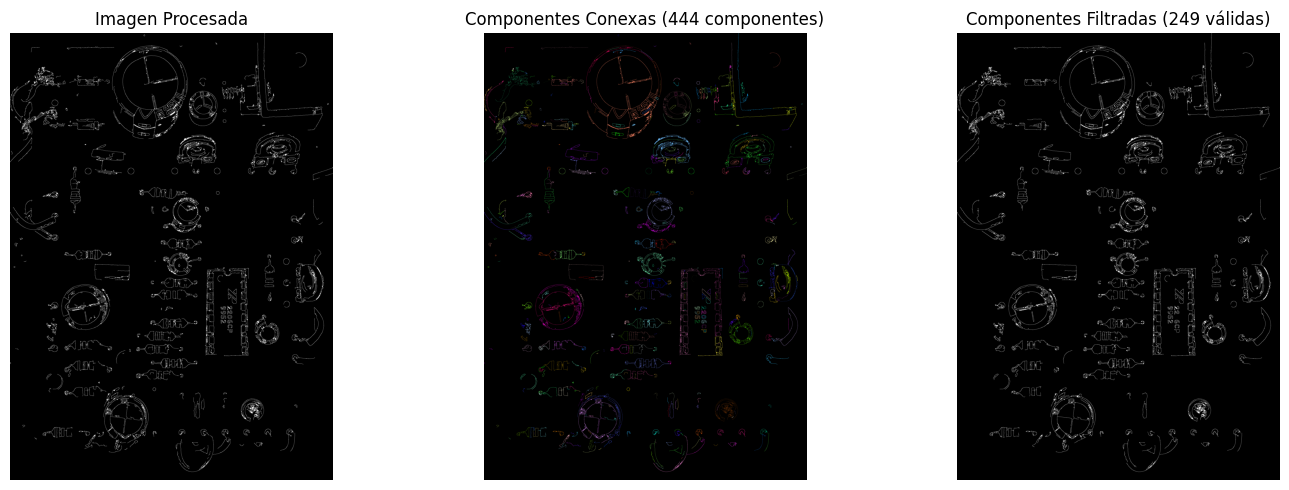

Componentes válidas después del filtrado: 249
Áreas de las componentes válidas:
  Componente 1: 1085 píxeles
  Componente 4: 308 píxeles
  Componente 5: 407 píxeles
  Componente 7: 414 píxeles
  Componente 8: 1314 píxeles
  Componente 11: 317 píxeles
  Componente 12: 140 píxeles
  Componente 14: 204 píxeles
  Componente 15: 9773 píxeles
  Componente 16: 613 píxeles


In [187]:
# Encontrar componentes conexas
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(imagen_cerrada, connectivity=8)

print(f"Número total de componentes conexas encontradas: {num_labels - 1}")  # -1 porque incluye el fondo

# Crear imagen coloreada para visualizar componentes
labels_colored = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)

# Asignar colores aleatorios a cada componente
colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]  # Fondo en negro

for i in range(num_labels):
    labels_colored[labels == i] = colors[i]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(imagen_cerrada, cmap='gray')
plt.title('Imagen Procesada')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(labels_colored)
plt.title(f'Componentes Conexas ({num_labels-1} componentes)')
plt.axis('off')

# Filtrar componentes por área
min_area = 100  # Área mínima
max_area = 10000  # Área máxima

imagen_filtrada = np.zeros_like(imagen_cerrada)
componentes_validos = []

for i in range(1, num_labels):  # Empezar desde 1 para excluir el fondo
    area = stats[i, cv2.CC_STAT_AREA]
    if min_area < area < max_area:
        imagen_filtrada[labels == i] = 255
        componentes_validos.append(i)

plt.subplot(1, 3, 3)
plt.imshow(imagen_filtrada, cmap='gray')
plt.title(f'Componentes Filtradas ({len(componentes_validos)} válidas)')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Componentes válidas después del filtrado: {len(componentes_validos)}")
print(f"Áreas de las componentes válidas:")
for i in componentes_validos[:10]:  # Mostrar solo las primeras 10
    area = stats[i, cv2.CC_STAT_AREA]
    print(f"  Componente {i}: {area} píxeles")

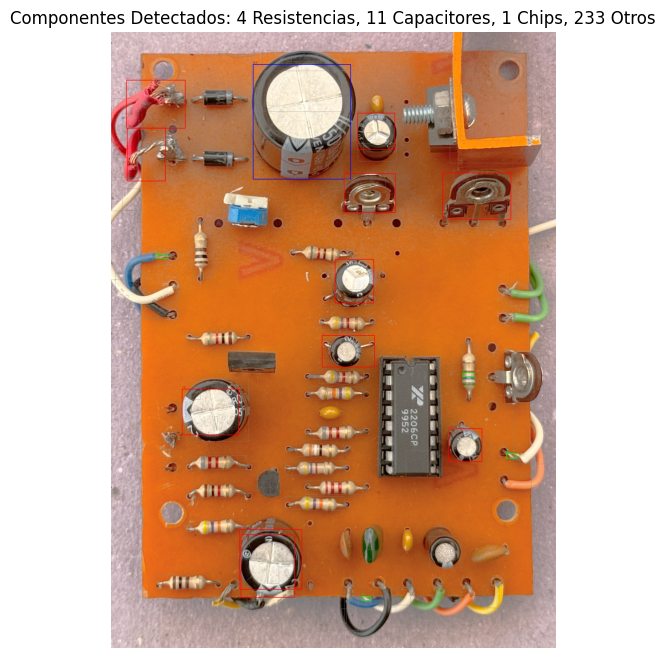


=== RESUMEN DE DETECCIÓN ===
🟢 RESISTENCIAS: 4
🔵 CAPACITORES: 11
🔴 CHIPS/ICs: 1
⚪ OTROS: 233
📊 TOTAL: 249

Resistencias detectadas (área promedio: 176):
  R1: posición (217,1078), tamaño 55x20, área 295
  R2: posición (1703,1651), tamaño 55x20, área 153
  R3: posición (1914,2044), tamaño 48x22, área 148
  R4: posición (1215,2736), tamaño 43x21, área 109

Capacitores detectados (área promedio: 3152):
  C1: posición (74,233), tamaño 285x233, área 3475
  C2: posición (1194,393), tamaño 180x177, área 2386
  C3: posición (78,465), tamaño 185x257, área 2628
  C4: posición (1606,683), tamaño 330x226, área 3948
  C5: posición (1129,686), tamaño 248x189, área 3950

Chips detectados (área promedio: 9773):
  IC1: posición (688,157), tamaño 472x556, área 9773


In [192]:
# Crear copia de la imagen original para dibujar
resultado = imagen_rgb.copy()

# Listas para almacenar diferentes tipos de componentes
resistencias = []
capacitores = []
chips = []
otros = []

# Analizar cada componente válida
for i in componentes_validos:
    # Obtener estadísticas del componente
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    
    # Calcular aspect ratio
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0
    
    # Clasificar según características geométricas
    if 100 < area < 10000 and 2 < aspect_ratio < 5 and 20 < w < 60 and 8 < h < 25:
        # Probablemente una resistencia
        resistencias.append((x, y, w, h, area))
        cv2.rectangle(resultado, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(resultado, f'R{len(resistencias)}', (x, y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
        
    elif area > 2000 and 1.0 < aspect_ratio < 2.0:
        # Probablemente un capacitor o chip
        if area > 5000:
            chips.append((x, y, w, h, area))
            cv2.rectangle(resultado, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(resultado, f'IC{len(chips)}', (x, y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)
        else:
            capacitores.append((x, y, w, h, area))
            cv2.rectangle(resultado, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(resultado, f'C{len(capacitores)}', (x, y-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
    else:
        # Otros componentes
        otros.append((x, y, w, h, area))
        cv2.rectangle(resultado, (x, y), (x + w, y + h), (128, 128, 128), 1)

# Mostrar resultado final
plt.figure(figsize=(12, 8))
plt.imshow(resultado)
plt.title(f'Componentes Detectados: {len(resistencias)} Resistencias, {len(capacitores)} Capacitores, {len(chips)} Chips, {len(otros)} Otros')
plt.axis('off')
plt.show()

# Resumen de resultados
print("\n=== RESUMEN DE DETECCIÓN ===")
print(f"🟢 RESISTENCIAS: {len(resistencias)}")
print(f"🔵 CAPACITORES: {len(capacitores)}")
print(f"🔴 CHIPS/ICs: {len(chips)}")
print(f"⚪ OTROS: {len(otros)}")
print(f"📊 TOTAL: {len(resistencias) + len(capacitores) + len(chips) + len(otros)}")

# Mostrar detalles de cada tipo
if resistencias:
    print(f"\nResistencias detectadas (área promedio: {np.mean([r[4] for r in resistencias]):.0f}):")
    for i, (x, y, w, h, area) in enumerate(resistencias[:5]):  # Mostrar solo las primeras 5
        print(f"  R{i+1}: posición ({x},{y}), tamaño {w}x{h}, área {area}")

if capacitores:
    print(f"\nCapacitores detectados (área promedio: {np.mean([c[4] for c in capacitores]):.0f}):")
    for i, (x, y, w, h, area) in enumerate(capacitores[:5]):
        print(f"  C{i+1}: posición ({x},{y}), tamaño {w}x{h}, área {area}")

if chips:
    print(f"\nChips detectados (área promedio: {np.mean([c[4] for c in chips]):.0f}):")
    for i, (x, y, w, h, area) in enumerate(chips):
        print(f"  IC{i+1}: posición ({x},{y}), tamaño {w}x{h}, área {area}")